In [1]:
import os
import glob
import cv2
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

Load Test Frames

In [2]:
images = []
for file in glob.glob("png/*.jpg"):
    im = cv2.imread(file)
    im = cv2.resize(im, (240, 240), interpolation=cv2.INTER_AREA)
    images.append(im)

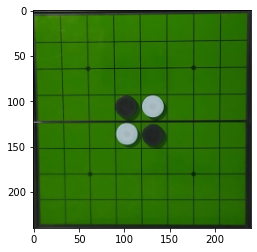

In [3]:
test_image = deepcopy(images[0])
plt.imshow(test_image)
plt.show()

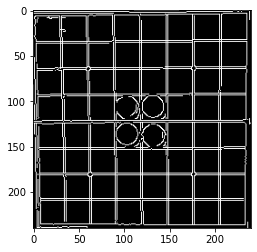

In [4]:
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 25, 50, apertureSize=3)
plt.imshow(edges, cmap="gray")
plt.show()

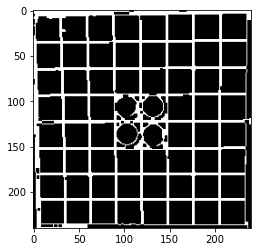

In [5]:
kernel = np.ones((3, 3), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)
kernel = np.ones((3, 3), np.uint8)
edges = cv2.erode(edges, kernel, iterations=1)
# cv2.imwrite("canny.jpg", edges)
plt.imshow(edges, cmap="gray")
plt.show()

In [6]:
lines = cv2.HoughLines(edges,1,np.pi/180,170)
# lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)

if not lines.any():
    print('No lines were found')
    exit()

filter = True

if filter:
    # rho_threshold = 100
    # theta_threshold = 1
    rho_threshold = 15
    theta_threshold = 0.1

    # how many lines are similar to a given one
    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                similar_lines[i].append(j)

    # ordering the INDECES of the lines by how many are similar to them
    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    # line flags is the base for the filtering
    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

print('number of Hough lines:', len(lines))

number of Hough lines: 40


In [7]:
filtered_lines = []

if filter:
    for i in range(len(lines)): # filtering
        if line_flags[i]:
            filtered_lines.append(lines[i])

    print('Number of filtered lines:', len(filtered_lines))
else:
    filtered_lines = lines

Number of filtered lines: 22


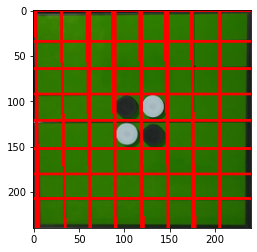

In [8]:
line_coords = []
tmp_img = deepcopy(test_image)
for line in filtered_lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    line_coords.append([x1, y1, x2, y2])

    cv2.line(tmp_img,(x1,y1),(x2,y2),(255, 0, 0),2)
# for line in filtered_lines:
#     l = line[0]
#     cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)

# cv2.imwrite('hough.jpg',test_image)
plt.imshow(tmp_img)
plt.show()

In [9]:
horizontal_lines = []
vertical_lines = []

for l in line_coords:
    if abs(l[0]-l[2]) > abs(l[1]-l[3]):
        horizontal_lines.append(l)
    else :
        vertical_lines.append(l)

horizontal_lines.sort(key=lambda x:x[1])
vertical_lines.sort(key=lambda x:x[0])

8


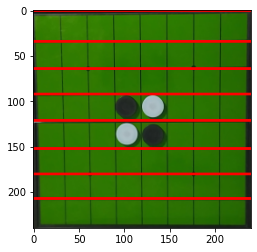

In [10]:
tmp_image = deepcopy(test_image)
print(len(horizontal_lines))
for l in horizontal_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

14


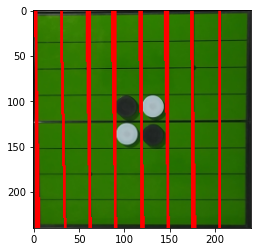

In [11]:
tmp_image = deepcopy(test_image)
print(len(vertical_lines))
for l in vertical_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

In [12]:
#delete close lines and add lines 
i = 0
while True:
    if i >= len(horizontal_lines)-1:
        break
    if horizontal_lines[i][1]<0:
        horizontal_lines.pop(i)
    dist = min(horizontal_lines[i+1][1]-horizontal_lines[i][1],
                horizontal_lines[i+1][3]-horizontal_lines[i][3]) 
    if dist < 10:
        horizontal_lines.pop(i)
    if dist > 50:
        new_line = [
            horizontal_lines[i][0],
            horizontal_lines[i][1]+int(dist/2),
            horizontal_lines[i][2],
            horizontal_lines[i][3]+int(dist/2)
        ]
        horizontal_lines.insert(i+1, new_line)
    i += 1

i = 0
while True:
    if i >= len(vertical_lines)-1:
        break
    if vertical_lines[i][0]<0:
        vertical_lines.pop(i)
    dist = min(vertical_lines[i+1][0]-vertical_lines[i][0],
                vertical_lines[i+1][2]-vertical_lines[i][2])
    if dist < 10:
        vertical_lines.pop(i+1)
    if dist > 50:
        new_line = [
            vertical_lines[i][0]+int(dist/2),
            vertical_lines[i][1],
            vertical_lines[i][2]+int(dist/2),
            vertical_lines[i][3]
        ]
        vertical_lines.insert(i+1, new_line)
    i += 1

8


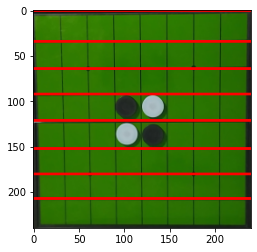

In [13]:
tmp_image = deepcopy(test_image)
print(len(horizontal_lines))
for l in horizontal_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

8


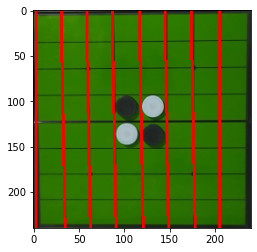

In [14]:
tmp_image = deepcopy(test_image)
print(len(vertical_lines))
for l in vertical_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

In [35]:
def get_grids(h_lines, v_lines, img, green_range=[[0, 70, 0], [100, 255, 100]]):
    widths = [v_lines[i+1][0]-v_lines[i][0] for i in range(len(v_lines)-1)]
    cell_width = int(np.mean(widths))
    heights = [h_lines[i+1][1]-h_lines[i][1] for i in range(len(v_lines)-1)]
    cell_height = int(np.mean(heights))
    lower = np.array(green_range[0], dtype = "uint8")
    upper = np.array(green_range[1], dtype = "uint8")
    
    n = 0
    while len(h_lines)<9 and n<2:
        first_line = h_lines[0]
        start_y = first_line[1]
        if start_y==0:
            start_y=1
        img_portion = img[:][0:start_y]
        mask = cv2.inRange(img_portion, lower, upper)
        green_area = cv2.bitwise_and(img_portion, img_portion, mask = mask)
        n += 1
        if sum(sum(sum(green_area)))>0 and h_lines[0][1]-cell_height>=0:
            new_line = [
                h_lines[0][0], 
                h_lines[0][1]-cell_height,
                h_lines[0][2],
                h_lines[0][3]-cell_height
                ]
            h_lines.insert(0, new_line)
        else :
            last_line = h_lines[-1]
            start_y = last_line[1]
            img_portion = img[:][start_y:]
            mask = cv2.inRange(img_portion, lower, upper)
            green_area = cv2.bitwise_and(img_portion, img_portion, mask = mask)
            n += 1
            if sum(sum(sum(green_area)))>0 and h_lines[-1][1]+cell_height<=img.shape[1]:
                new_line = [
                    h_lines[-1][0], 
                    h_lines[-1][1]+cell_height,
                    h_lines[-1][2],
                    h_lines[-1][3]+cell_height
                    ]
                h_lines.append(new_line)
    
    n = 0
    while len(v_lines)<9 and n<2:
        first_line = v_lines[0]
        start_x = first_line[0]
        if start_x==0:
            start_x = 1
        img_portion = img[:start_x][:]
        mask = cv2.inRange(img_portion, lower, upper)
        green_area = cv2.bitwise_and(img_portion, img_portion, mask = mask)
        # plt.imshow(green_area)
        # plt.show()
        # print(sum(sum(green_area)))
        n += 1
        if sum(sum(sum(green_area)))>0 and v_lines[0][0]-cell_width>=0:
            new_line = [
                v_lines[0][0]-cell_width, 
                v_lines[0][1],
                v_lines[0][2]-cell_width,
                v_lines[0][3]
                ]
            v_lines.insert(0, new_line)
        else :
            last_line = v_lines[-1]
            start_x = last_line[0]
            img_portion = img[start_x:][:]
            mask = cv2.inRange(img_portion, lower, upper)
            green_area = cv2.bitwise_and(img_portion, img_portion, mask = mask)
            n += 1
            if sum(sum(sum(green_area)))>0 and v_lines[-1][0]+cell_width<=img.shape[0]:
                new_line = [
                    v_lines[-1][0]+cell_width, 
                    v_lines[-1][1],
                    v_lines[-1][2]+cell_width,
                    v_lines[-1][3]
                ]
                v_lines.append(new_line)
    grids = []
    for j in range(len(v_lines)-1):
        grid_row = []
        for i in range(len(h_lines)-1):
            # grid_row.append([ 
            #     int(np.mean([v_lines[j][0], v_lines[j][2]])),
            #     int(np.mean([h_lines[i][1], h_lines[i][3]])),
            #     int(np.mean([v_lines[j+1][0], v_lines[j+1][2]])),
            #     int(np.mean([h_lines[i+1][1], h_lines[i+1][3]]))
            # ])
            grid_row.append([ 
                [v_lines[j][0], v_lines[j][2]],
                [h_lines[i][1], h_lines[i][3]],
                [v_lines[j+1][0], v_lines[j+1][2]],
                [h_lines[i+1][1], h_lines[i+1][3]]
            ])
        grids.append(grid_row)
    return grids

In [36]:
grids = get_grids(horizontal_lines, vertical_lines, test_image)

9


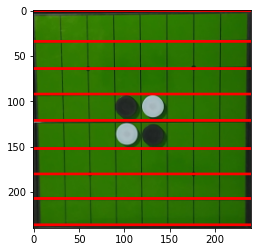

In [37]:
tmp_image = deepcopy(test_image)
print(len(horizontal_lines))
for l in horizontal_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

9


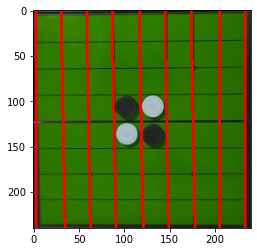

In [38]:
tmp_image = deepcopy(test_image)
print(len(vertical_lines))
for l in vertical_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

In [43]:
def is_color_in_range(color, range):
    min_vals = range[0]
    max_vals = range[1]
    for i, c in enumerate(color):
        if c < min_vals[i] or c > max_vals[i]:
            return False
    return True
    
def plot_grids(grids, img, 
                    black_range=[[0, 0, 0], [60, 60, 60]], 
                    white_range=[[150, 150, 150], [255, 255, 255]]):
    for g_row in grids:
        for c in g_row:
            # cell_height = c[3]-c[1]
            # cell_width = c[2]-c[0]
            # cell = img[c[0]:c[0]+cell_width, c[1]:c[1]+cell_height]
            # center = [c[1]+cell_height//3, c[0]+cell_width//2]
            # plt.imshow(cell)
            # plt.show()
            cell = img[c[0]:]

            #find dominant color
            pixels = np.float32(cell.reshape(-1, 3))
            n_colors = 3
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
            flags = cv2.KMEANS_RANDOM_CENTERS
            _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
            _, counts = np.unique(labels, return_counts=True)
            dominant = palette[np.argmax(counts)]
            # print(dominant)
            
            #separate black, white, and empty with thresholding
            if is_color_in_range(dominant, black_range):
                cv2.putText(img, "-1", (center[0], center[1]), 
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=0.4,
                            color=(255, 0, 0), 
                            thickness=2)
            elif is_color_in_range(dominant, white_range):
                cv2.putText(img, "1", (center[0], center[1]), 
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=0.4,
                            color=(255, 0, 0), 
                            thickness=2)
            else :
                cv2.putText(img, "0", (center[0], center[1]), 
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=0.4,
                            color=(255, 0, 0), 
                            thickness=2)
    return 

In [44]:
tmp_image = deepcopy(test_image)
plot_grids(grids, tmp_image)
plt.imshow(tmp_image)
plt.show()

[[3, 3], [0, 0], [13, 48], [33, 34]]


NameError: name 'cell' is not defined